## Assignment 2: $k$ Nearest Neighbor

### Do any four.

In [2]:
! git clone https://github.com/JasonYe05/scratchpad
%run ./scratchpad/get_data.py

fatal: destination path 'scratchpad' already exists and is not an empty directory.
Download complete
Extracting data files...
Data extracted


**Q1.** Please answer the following questions.
1. What is the difference between regression and classification?
2. What is a confusion table/matrix? What does it help us understand about a model's performance?
3. What is Accuracy? Why might it not be entirely sufficient to evaluate a classifer's predictive performance?
4. What does the root mean squared error quantify about a particular model?
5. What are overfitting and underfitting?
6. Why does splitting the data into training and testing sets, and choosing $k$ by evaluating accuracy or RMSE on the test set, improve model performance?
7. With classification, we can report a class label as a prediction or a probability distribution over class labels. Please explain the strengths and weaknesses of each approach.

1. The difference between the two is that when you use categorical variables you are doing classificaiton. And when working with numeric variables you are working with regression.
2. A confusion matrix is a classification of tasks, our most basic metric of "Did it work?." It helps us cross tabulate the true labels with predicted ones, to be able to see if they align.
3. Accuracy is the proportion of predictors we get correct in the classifier. It's not sufficient because it sometimes fails to account for imbalances.
4. It quantifies the size of a model's prediction errors.
5. Overfitting: Picking a k that's too low causing the model to be overly senstive. Underfitting: Picking a k that's too high.
6. We want to avoid under/over fitting by building robust, complex models. And we split data into training and testing. Training data consists of 80% of the sample and test data is 20% of the sample.
7. predict a class label: strengths: simple, easy to interpret weaknesses: hides uncertainty. Probability distribution over class labels: strengths: shows uncertainty weaknesses: harder to explain

**Q2.** This is a case study on $k$ nearest neighbor classification, using the `land_mines.csv` data.

The data consists of a label, `mine_type`, taking integer values 1 to 5, and three properties of the mine, `voltage`, `height` and `soil`. We want to predict the kind of mine from data about it. Imagine working for the DOD or a humanitarian aid agency, trying to help people remove land mines more safely.

1. Load the data. Perform some EDA, summarizing the target label and the relationships between the features (e.g. scatterplots, describe tables).
2. Split the sample 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be, in my experience: Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)
3. Build a $k$-NN classifier. Explain how you select $k$.
4. Print a confusion table for your best model, comparing predicted and actual class label on the test set. How accurate is it? Where is performance more or less accurate?
5. Notice that you can have a lot of accurate predictions for a given type of mine, but still make a lot of mistakes. Please explain how you'd advise someone to actually use this predictive model in practice, given the errors that it tends to make.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

df = pd.read_csv("./data/land_mines.csv")
df.head()

,voltage,height,soil,mine_type
0,0.338157,0.000000,0.0,1
1,0.320241,0.181818,0.0,1
2,0.287009,0.272727,0.0,1
3,0.256284,0.454545,0.0,1
4,0.262840,0.545455,0.0,1


In [6]:
#1
df["mine_type"].value_counts().sort_index()
df[["voltage","height","soil"]].describe()

,voltage,height,soil
count,338.000000,338.000000,338.000000
mean,0.430634,0.508876,0.503550
std,0.195819,0.306043,0.344244
min,0.197734,0.000000,0.000000
25%,0.309737,0.272727,0.200000
50%,0.359516,0.545455,0.600000
75%,0.482628,0.727273,0.800000
max,0.999999,1.000000,1.000000


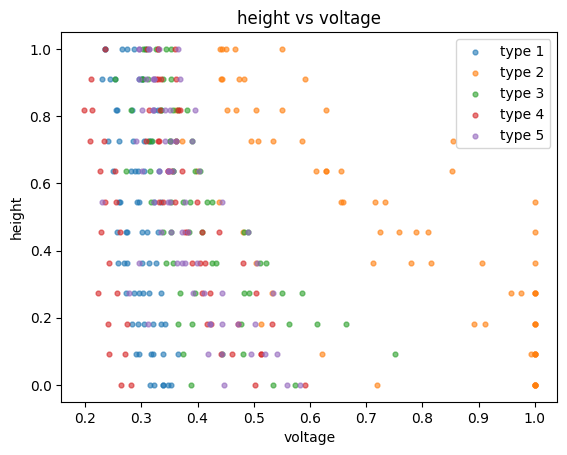

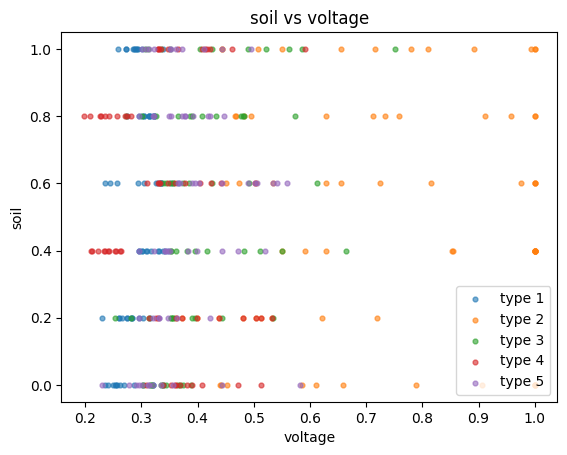

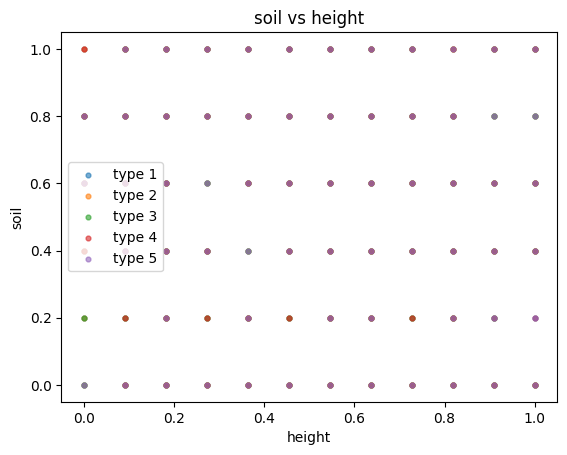

In [9]:
features = ["voltage","height","soil"]
pairs = [("voltage","height"), ("voltage","soil"), ("height","soil")]

for x, y in pairs:
    plt.figure()
    for t in sorted(df["mine_type"].unique()):
        sub = df[df["mine_type"] == t]
        plt.scatter(sub[x], sub[y], s=12, alpha=0.6, label=f"type {t}")
    plt.xlabel(x); plt.ylabel(y)
    plt.title(f"{y} vs {x}")
    plt.legend()
    plt.show()


In [10]:
#2
Z = df[["voltage","height","soil"]]
y = df["mine_type"]

Z_train, Z_test, y_train, y_test = train_test_split(
    Z, y,
    test_size=0.5,
    random_state=42,
    stratify=y
)
y_train.value_counts().sort_index(), y_test.value_counts().sort_index()

(mine_type
 1    35
 2    35
 3    33
 4    33
 5    33
 Name: count, dtype: int64,
 mine_type
 1    36
 2    35
 3    33
 4    33
 5    32
 Name: count, dtype: int64)

In [13]:
#3
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])


#ChatGPT
ks = list(range(1, 51, 2))  # this creates a range of k values to try
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # this line defines the splitting rule

mean_scores = []
for k in ks:
    pipe.set_params(knn__n_neighbors=k)
    scores = cross_val_score(pipe, Z_train, y_train, cv=cv, scoring="accuracy") # this line here computes accuracy
    mean_scores.append(scores.mean())

best_k = ks[int(np.argmax(mean_scores))]
best_k, max(mean_scores)


(5, np.float64(0.4855614973262032))

k=5 and CV ~0.486

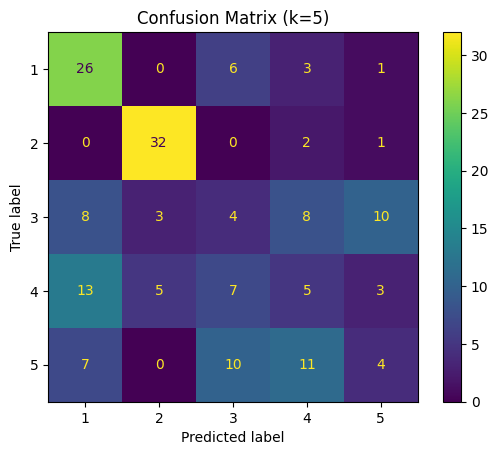

              precision    recall  f1-score   support

           1      0.481     0.722     0.578        36
           2      0.800     0.914     0.853        35
           3      0.148     0.121     0.133        33
           4      0.172     0.152     0.161        33
           5      0.211     0.125     0.157        32

    accuracy                          0.420       169
   macro avg      0.363     0.407     0.377       169
weighted avg      0.371     0.420     0.387       169



In [14]:
#4
best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=best_k))
])

best_model.fit(Z_train, y_train)

y_pred = best_model.predict(Z_test)

acc = accuracy_score(y_test, y_pred)
acc

labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d")
plt.title(f"Confusion Matrix (k={best_k})")
plt.show()

print(classification_report(y_test, y_pred, digits=3))


Best: Type 2 with 0.914, Type 1 with 0.722
Worst: Type 3 with 0.121, Type 4 with 0.152, Type 5 with 0.125.
The overall accuracy rate is 42% so less than half.

5. A few things you could do is use the model by its strong points. Like for Type 2 it was 0.914 which means it's really realiable for that Type. Another thing you could do update the model by heavily testing (collect more data, etc).

**Q3.** This question is a case study for $k$ nearest neighbor regression, using the `USA_cars_datasets.csv` data.

The target variable `y` is `price` and the features are `year` and `mileage`.

1. Load the `./data/USA_cars_datasets.csv`. Keep the following variables and drop the rest: `price`, `year`, `mileage`. Are there any `NA`'s to handle? Look at the head and dimensions of the data.
2. Maxmin normalize `year` and `mileage`.
3. Split the sample into ~80% for training and ~20% for hyper-parameter selection and evaluation.
4. Use the $k$-NN algorithm and the training data to predict `price` using `year` and `mileage` for the test set for $k=3,10,25,50,100,300$. For each value of $k$, compute the mean squared error and print a scatterplot showing the test value plotted against the predicted value. What patterns do you notice as you increase $k$?
5. Determine the optimal $k$ for these data.
6. Describe what happened in the plots of predicted versus actual prices as $k$ varied, taking your answer into part 6 into account. (Hint: Use the words "underfitting" and "overfitting".)

**Q4.** This question is a case study for $k$ nearest neighbor regression, using the `heart_failure_clinical_records_dataset.csv` data.

The data for the question include:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- death event: if the patient deceased during the follow-up period (boolean)

1. Load the `./data/heart_failure_clinical_records_dataset.csv`. Are there any `NA`'s to handle? use `.drop()` to remove `time` from the dataframe.
2. Make a correlation matrix. What variables are strongly associated with a death event?
3. For the dummy variables `anaemia`, `diabetes`, `high_blood_pressure`, `sex`, and `smoking`, compute a summary table of `DEATH_EVENT` grouped by the variable. For which variables does a higher proportion of the population die when the variable takes the value 1 rather than 0?
4. On the basis of your answers from 2 and 3, build a matrix $X$ of the variables you think are most predictive of a death, and a variable $y$ equal to `DEATH_EVENT`.
5. Maxmin normalize all of the variables in `X`.
6. Split the sample into ~80% for training and ~20% for evaluation. (Try to use the same train/test split for the whole question, so that you're comparing apples to apples in the questions below.).
7. Determine the optimal number of neighbors for a $k$-NN classification or regression for the variables you selected.
8. OK, do steps 5 through 7 again, but use all of the variables (except `time`). Which model has the best Mean Squared Error? Which would you prefer to use in practice, if you had to predict `DEATH_EVENT`s? If you play with the selection of variables, how much does the RMSE change for your fitted model on the test data? Are more variables always better? Explain your findings.

**Q5.** This is a case study on $k$ nearest neighbor classification, using the `animals.csv` data.

The data consist of a label, `class`, taking integer values 1 to 7, the name of the species, `animal`, and 16 characteristics of the animal, including `hair`, `feathers`, `milk`, `eggs`, `airborne`, and so on.

1. Load the data. For each of the seven class labels, print the values in the class and get a sense of what is included in that group. Perform some other EDA: How big are the classes? How much variation is there in each of the features/covariates? Which variables do you think will best predict which class?
2. Split the data 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be. Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)
3. Using all of the variables, build a $k$-NN classifier. Explain how you select $k$.
4. Print a confusion matrix for the optimal model, comparing predicted and actual class label on the test set. How accurate it is? Can you interpret why mistakes are made across groups?
5. Use only `milk`, `aquatic`, and `airborne` to train a new $k$-NN classifier. Print your confusion table. Mine does not predict all of the classes, only a subset of them. To see the underlying proportions/probabilities, use `model.predict_proba(X_test.values)` to predict probabilities rather than labels for your `X_test` test data for your fitted `model`. Are all of the classes represented? Explain your results.

**Q6.** This is a case study using $k$ nearest neighbor regression for imputation, using the `airbnb_hw.csv` data.

There are 30,478 observations, but only 22,155 ratings. We're going to build a kNN regressor to impute missing values. This is a common task, and illustrates one way you can use kNN in the future even when you have more advanced models available.

1. Load the `airbnb_hw.csv` data with Pandas. We're only going to use `Review Scores Rating`, `Price`, and `Beds`, so use `.loc` to column filter the dataframe to those variables.
2. Set use `.isnull()` and `.loc` to select the subset of the dataframe with missing review values. Set those aside in a different dataframe. We'll make predictions about them later.
3. Use `df = df.dropna(axis = 0, how = 'any')` to eliminate any observations with missing values/NA's from the dataframe.
4. For the complete cases, create a $k$-NN model that uses the variables `Price` and `Beds` to predict `Review Scores Rating`. How do you choose $k$? (Hint: Train/test split, iterate over reasonable values of $k$ and find a value that minimizes SSE on the test split using predictions from the training set.)
5. Predict the missing ratings.
6. Do a kernel density plot of the training ratings and the predicted missing ratings. Do they look similar or not? Describe what you see.

**Q7.** Let's do some very basic computer vision. We're going to import the MNIST handwritten digits data and use $k$-NN to predict values (i.e. "see/read").

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a list of matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use the reshaped `X_test` and `y_test` data to create a $k$-nearest neighbor classifier of digit. What is the optimal number of neighbors $k$? If you can't determine this, play around with different values of $k$ for your classifier.
5. For the optimal number of neighbors, how well does your predictor perform on the test set? Report the accuracy, compute a confusion matrix, and explain your findings.
6. For your confusion matrix, which mistakes are most likely? Do you find any interesting patterns?
7. So, this is how computers "see." They convert an image into a matrix of values, that matrix becomes a vector in a dataset, and then we deploy ML tools on it as if it was any other kind of tabular data. To make sure you follow this, invent a way to represent a color photo in matrix form, and then describe how you could convert it into tabular data. (Hint: RGB color codes provide a method of encoding a numeric value that represents a color.)

In [15]:
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


7 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 222 254 254 254 254 241 198 198 198 198 198 198 19

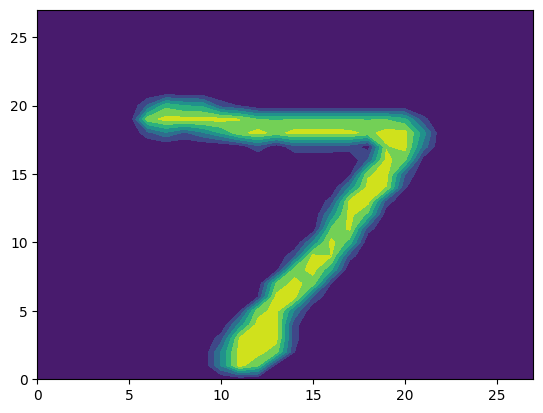

2 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 116 125 171 255 255 150  93   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 169 253 253 253 253 253 253 218  30   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 169 253 253 253 213 142 176 253 253 122   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  52 250 253 210  32  12   0   6 206 253 140   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  77 251 210  25   0   0   0 122 248 253  65   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  31  18   0   0   0   0 209 253 253  65   

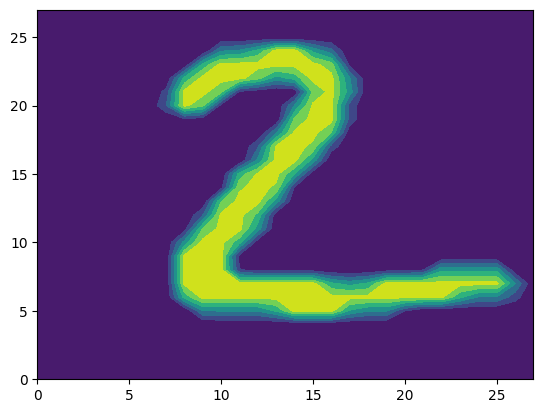

1 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  38 254 109   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  87 252  82   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 135 241   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  45 244 150   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  84 254  63   

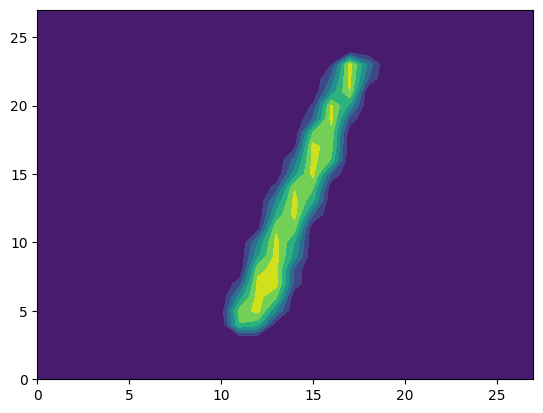

0 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  11 150 253 202  31   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  37 251 251 253 107   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  21 197 251 251 253 107   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 110 190 251 251 251 253 169 109  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 253 251 251 251 251 253 251 251 22

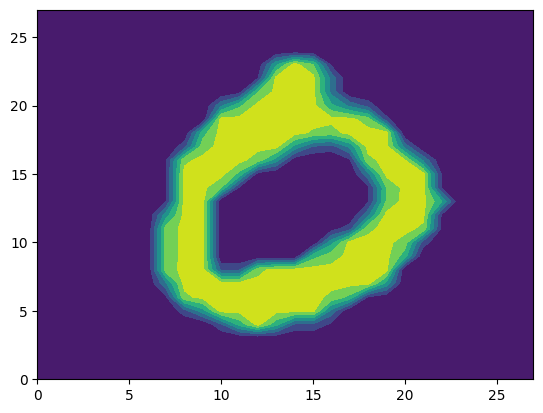

4 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  50 224   0   0   0   0   0   0   0  70  29   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 121 231   0   0   0   0   0   0   0 148 168   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   4 195 231   0   0   0   0   0   0   0  96 210  11   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  69 252 134   0   0   0   0   0   0   

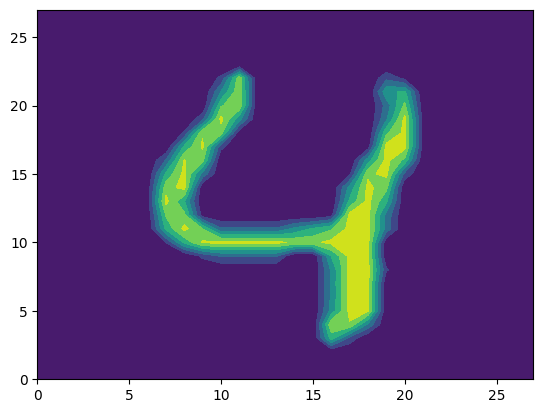

In [16]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()

In [20]:
#2
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("X_train[i]:", X_train[0].shape)
print("X_test[i] :", X_test[0].shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


X_train: (60000, 28, 28)
X_test : (10000, 28, 28)
X_train[i]: (28, 28)
X_test[i] : (28, 28)
y_train: (60000,)
y_test : (10000,)


In [21]:
#3
X = X_train.reshape(X_train.shape[0], 784)

X_te = X_test.reshape(X_test.shape[0], 784)

print(X.shape, X_te.shape)


(60000, 784) (10000, 784)


In [22]:
#4
Xtr = X_train.reshape(X_train.shape[0], 784) / 255.0
Xte = X_test.reshape(X_test.shape[0], 784) / 255.0
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_values = [1, 3, 5, 7, 9, 11, 15, 21]
accs = {}

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtr, y_train)
    pred = knn.predict(Xte)
    acc = accuracy_score(y_test, pred)
    accs[k] = acc
    print(f"k={k:>2}  accuracy={acc:.4f}")

best_k = max(accs, key=accs.get)
print("\nBest k:", best_k, "with accuracy", accs[best_k])


k= 1  accuracy=0.9691
k= 3  accuracy=0.9705
k= 5  accuracy=0.9688
k= 7  accuracy=0.9694
k= 9  accuracy=0.9659
k=11  accuracy=0.9668
k=15  accuracy=0.9633
k=21  accuracy=0.9630

Best k: 3 with accuracy 0.9705


5. 3 is the optimal number of neighbors. With a accuracy of 0.9705.
6. A mistake that could most likely happen is probalby the diagonal entries in the confusion matrix.like in MNIST the most look alike confusions can be 4&9, 7&1, 5&8...
7. One way to represent a color photo is a 3D matrix. One way to conter it into tabular data is by flattening the image into one row.